# Detekce osob a vizidel pomocí TensorFlow Object Detection API
Tento notebook byl z velké části inspirován [oficiální ukázkou v repozitáři od TensorFlow](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_from_saved_model_tf2_colab.ipynb).

## Stažení repozitáře s modely, instalace potřebných závislostí a jejich import

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

! pip3 install grpcio==1.34

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
%%bash

cd models/research/

protoc object_detection/protos/*.proto --python_out=.

cp object_detection/packages/tf2/setup.py .
pip3 install .

python3 object_detection/builders/model_builder_test.py

Defaulting to user installation because normal site-packages is not writeable
Processing /home/pehovorka/Dokumenty/street-object-detection/jupyter/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1655595 sha256=e000b7b49e4f5c39eb21e4d7865c3acf5c46d73feb1c981b02325725d271fae7
  Stored in directory: /tmp/pip-ephem-wheel-cache-squiwcol/wheels/71/54/f4/cac2879c6027b419023b1cbc083102bd9091f71dd67b40e9bd
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
2021-06-20 20:18:19.339477: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import io
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

%cd models/research
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

# Print available GPUs
tf.config.list_physical_devices()

/home/pehovorka/Dokumenty/street-object-detection/jupyter/models/research


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Načtení obrázku do numpy pole a definice labelů tříd

In [4]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be locif not os.path.exists('tensorflow_object_counting_api'):
  ! git clone https://github.com/ahmetozlu/tensorflow_object_counting_apigal or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load the COCO Label Map
category_index = {
    1: {'id': 1, 'name': 'person'},
    2: {'id': 2, 'name': 'bicycle'},
    3: {'id': 3, 'name': 'car'},
    4: {'id': 4, 'name': 'motorcycle'},
    5: {'id': 5, 'name': 'airplane'},
    6: {'id': 6, 'name': 'bus'},
    7: {'id': 7, 'name': 'train'},
    8: {'id': 8, 'name': 'truck'},
    9: {'id': 9, 'name': 'boat'},
    10: {'id': 10, 'name': 'traffic light'},
    11: {'id': 11, 'name': 'fire hydrant'},
    13: {'id': 13, 'name': 'stop sign'},
    14: {'id': 14, 'name': 'parking meter'},
    15: {'id': 15, 'name': 'bench'},
    16: {'id': 16, 'name': 'bird'},
    17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'},
    19: {'id': 19, 'name': 'horse'},
    20: {'id': 20, 'name': 'sheep'},
    21: {'id': 21, 'name': 'cow'},
    22: {'id': 22, 'name': 'elephant'},
    23: {'id': 23, 'name': 'bear'},
    24: {'id': 24, 'name': 'zebra'},
    25: {'id': 25, 'name': 'giraffe'},
    27: {'id': 27, 'name': 'backpack'},
    28: {'id': 28, 'name': 'umbrella'},
    31: {'id': 31, 'name': 'handbag'},
    32: {'id': 32, 'name': 'tie'},
    33: {'id': 33, 'name': 'suitcase'},
    34: {'id': 34, 'name': 'frisbee'},
    35: {'id': 35, 'name': 'skis'},
    36: {'id': 36, 'name': 'snowboard'},
    37: {'id': 37, 'name': 'sports ball'},
    38: {'id': 38, 'name': 'kite'},
    39: {'id': 39, 'name': 'baseball bat'},
    40: {'id': 40, 'name': 'baseball glove'},
    41: {'id': 41, 'name': 'skateboard'},
    42: {'id': 42, 'name': 'surfboard'},
    43: {'id': 43, 'name': 'tennis racket'},
    44: {'id': 44, 'name': 'bottle'},
    46: {'id': 46, 'name': 'wine glass'},
    47: {'id': 47, 'name': 'cup'},
    48: {'id': 48, 'name': 'fork'},
    49: {'id': 49, 'name': 'knife'},
    50: {'id': 50, 'name': 'spoon'},
    51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'},
    53: {'id': 53, 'name': 'apple'},
    54: {'id': 54, 'name': 'sandwich'},
    55: {'id': 55, 'name': 'orange'},
    56: {'id': 56, 'name': 'broccoli'},
    57: {'id': 57, 'name': 'carrot'},
    58: {'id': 58, 'name': 'hot dog'},
    59: {'id': 59, 'name': 'pizza'},
    60: {'id': 60, 'name': 'donut'},
    61: {'id': 61, 'name': 'cake'},
    62: {'id': 62, 'name': 'chair'},
    63: {'id': 63, 'name': 'couch'},
    64: {'id': 64, 'name': 'potted plant'},
    65: {'id': 65, 'name': 'bed'},
    67: {'id': 67, 'name': 'dining table'},
    70: {'id': 70, 'name': 'toilet'},
    72: {'id': 72, 'name': 'tv'},
    73: {'id': 73, 'name': 'laptop'},
    74: {'id': 74, 'name': 'mouse'},
    75: {'id': 75, 'name': 'remote'},
    76: {'id': 76, 'name': 'keyboard'},
    77: {'id': 77, 'name': 'cell phone'},
    78: {'id': 78, 'name': 'microwave'},
    79: {'id': 79, 'name': 'oven'},
    80: {'id': 80, 'name': 'toaster'},
    81: {'id': 81, 'name': 'sink'},
    82: {'id': 82, 'name': 'refrigerator'},
    84: {'id': 84, 'name': 'book'},
    85: {'id': 85, 'name': 'clock'},
    86: {'id': 86, 'name': 'vase'},
    87: {'id': 87, 'name': 'scissors'},
    88: {'id': 88, 'name': 'teddy bear'},
    89: {'id': 89, 'name': 'hair drier'},
    90: {'id': 90, 'name': 'toothbrush'},
}

## Stažení a načtení předtrénovaného modelu

In [5]:
# Download the pretrained model and put it into models/research/object_detection/test_data/
!wget -N http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
!tar -xf efficientdet_d5_coco17_tpu-32.tar.gz

test_data_dir = os.path.join('object_detection','test_data')
if not os.path.exists(test_data_dir):
    !mv efficientdet_d5_coco17_tpu-32/ test_data_dir
    
# Load pretrained model and count time needed for its loading.
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load(os.path.join(test_data_dir,'efficientdet_d5_coco17_tpu-32','saved_model'))
end_time = time.time()
elapsed_time = end_time - start_time
print('Model loading time: ' + str(elapsed_time) + 's')

--2021-06-20 20:18:23--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
Překládám download.tensorflow.org (download.tensorflow.org)… 172.217.23.208, 2a00:1450:4014:80c::2010
Navazuje se spojení s download.tensorflow.org (download.tensorflow.org)|172.217.23.208|:80… spojeno.
HTTP požadavek odeslán, program čeká na odpověď… 304 Not Modified
Soubor „efficientdet_d5_coco17_tpu-32.tar.gz“ nebyl na serveru změněn. Stažení se vynechává.



Model loading time: 44.99790549278259s


## Definice potřebných proměnných 

In [6]:
dataset_dir = os.path.join('..','..','..','dataset','theatre_dataset_images')
list_of_all_images = os.listdir(dataset_dir)
output_dir = os.path.join('..','..','..','tf_output')

# Create the output dir if it does not already exist.
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# The day (start of the filename) to analyze
day = '2021-06-04'

# Filter only the files whose filenames start with the chosen day
list_of_selected_images = [filename for filename in list_of_all_images if filename.startswith(day)]


# Create empty dict of hours with nested dict of watched classes.
# It will be later used for counting instances of such classes in particular hours.
hour_bins = {
    el: {
        'people': 0, 
        'cars': 0, 
        'bicycles': 0, 
        'dogs': 0,
        'buses': 0,
        'trains': 0
    } 
    for el in range(24)
}

## Detekce objektů, uložení obrázků s detekcemi a sčítání detekovaných objektů

In [7]:
elapsed = []
for i in range(len(list_of_selected_images)):
  # Count time needed for processing of one image.
  start_time = time.time()
    
  # Load image into numpy array and detect objects.
  image_path = os.path.join(dataset_dir, list_of_selected_images[i])
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  detections = detect_fn(input_tensor)

  # Copy the numpy array with the image.
  image_np_with_detections = image_np.copy()

  # Visualize boxes and labels on the copied image array. Use threshold 40% for min score.
  # Use categories labels from the COCO label map (as defined earlier).
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),        
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)

  # Save image with detections without visible axes to the output folder using the original name.
  fig = plt.figure(frameon=False)
  fig.set_size_inches(12,9)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(image_np_with_detections, aspect='auto')
  output_path = os.path.join(output_dir, list_of_selected_images[i])
  fig.savefig(output_path)
  plt.close(fig) 

  # Count all objects detected in the image that have min score of 40%.
  objects = []
  for index,value in enumerate(detections['detection_classes'][0].numpy()):
    if detections['detection_scores'][0,index].numpy() > .40:
        objects.append(category_index.get(value))
  
  # Filter only the classes we are interested in and count number of instances in the image.
  people = len(list(filter(lambda x: x['name'] == 'person', objects)))
  bicycles = len(list(filter(lambda x: x['name'] == 'bicycle', objects))) 
  cars = len(list(filter(lambda x: x['name'] == 'car', objects)))
  dogs = len(list(filter(lambda x: x['name'] == 'dog', objects)))
  buses = len(list(filter(lambda x: x['name'] == 'bus', objects)))
  trains = len(list(filter(lambda x: x['name'] == 'train', objects)))

  # Print number of instances.
  print(list_of_selected_images[i] + ': people: ' + str(people) + ' | cars: ' + str(cars) \
        + ' | bicycles: ' + str(bicycles) + ' | dogs: ' + str(dogs) + ' | buses: ' + str(buses) \
        + ' | trains: ' + str(trains))

  # Get hour from the filename using substring. The stable naming of files came in handy here.
  substr_hour = list_of_selected_images[i][11:13]
    
  # Sum found numbers of instances with the existing number of instances in the dictionary of particular hour.
  hour_bins[int(substr_hour)] = {
        'people': hour_bins[int(substr_hour)]['people'] + people, 
        'cars': hour_bins[int(substr_hour)]['cars'] + cars, 
        'bicycles': hour_bins[int(substr_hour)]['bicycles'] + bicycles, 
        'dogs': hour_bins[int(substr_hour)]['dogs'] + dogs,
        'buses': hour_bins[int(substr_hour)]['buses'] + buses,
        'trains': hour_bins[int(substr_hour)]['trains'] + trains
  }
    
  # Record end time and append the difference between start time and end time to the "elapsed" list.
  end_time = time.time()
  elapsed.append(end_time - start_time)
  
# Print total and average time.
average_elapsed = sum(elapsed) / float(len(elapsed))
print('Total time: ' + str(sum(elapsed)) + ' seconds')
print('Average time: ' + str(average_elapsed) + ' second per image')

2021-06-04 21:19:00.jpg: people: 7 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 03:48:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 04:37:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 14:16:01.jpg: people: 6 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 01:02:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 06:22:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 08:08:00.jpg: people: 1 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 18:20:01.jpg: people: 3 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 20:53:01.jpg: people: 12 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 03:33:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 07:30:01.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0

2021-06-04 21:52:00.jpg: people: 10 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 22:47:01.jpg: people: 9 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 15:13:01.jpg: people: 5 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 1
2021-06-04 07:06:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 02:44:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 15:08:00.jpg: people: 5 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 2
2021-06-04 04:53:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 05:41:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 11:26:00.jpg: people: 1 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 1
2021-06-04 06:50:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 06:20:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0

2021-06-04 10:31:01.jpg: people: 1 | cars: 1 | bicycles: 1 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 09:40:00.jpg: people: 0 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 13:59:00.jpg: people: 3 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 0
2021-06-04 06:56:01.jpg: people: 1 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 3
2021-06-04 07:11:01.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 14:53:01.jpg: people: 2 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 16:15:01.jpg: people: 1 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 22:53:00.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 21:41:01.jpg: people: 7 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 2
2021-06-04 05:21:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 03:40:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 

2021-06-04 21:46:01.jpg: people: 1 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 09:02:00.jpg: people: 4 | cars: 6 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 0
2021-06-04 00:11:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 14:02:00.jpg: people: 5 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 16:28:00.jpg: people: 7 | cars: 7 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 12:17:00.jpg: people: 1 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 02:52:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 01:40:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 01:42:01.jpg: people: 2 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 19:06:01.jpg: people: 13 | cars: 6 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 00:05:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0

2021-06-04 08:00:00.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 1
2021-06-04 19:53:00.jpg: people: 10 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 05:00:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 13:53:01.jpg: people: 12 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 04:33:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 09:46:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 0
2021-06-04 13:05:00.jpg: people: 2 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 11:04:00.jpg: people: 3 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 21:26:00.jpg: people: 11 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 08:24:01.jpg: people: 1 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 09:47:00.jpg: people: 4 | cars: 2 | bicycles: 0 | dogs: 0 | buses:

2021-06-04 23:34:00.jpg: people: 5 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 08:12:01.jpg: people: 0 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 13:13:00.jpg: people: 6 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 22:40:00.jpg: people: 1 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 23:22:01.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 2
2021-06-04 00:21:01.jpg: people: 4 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 20:18:00.jpg: people: 3 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 17:23:01.jpg: people: 6 | cars: 7 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 00:00:00.jpg: people: 5 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 10:06:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 01:04:00.jpg: people: 0 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 

2021-06-04 06:36:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 2
2021-06-04 14:57:00.jpg: people: 4 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 20:00:00.jpg: people: 10 | cars: 2 | bicycles: 0 | dogs: 1 | buses: 0 | trains: 0
2021-06-04 05:31:01.jpg: people: 2 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 1
2021-06-04 06:21:00.jpg: people: 1 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 00:18:01.jpg: people: 1 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 17:44:01.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 17:38:01.jpg: people: 1 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 2
2021-06-04 14:54:01.jpg: people: 9 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 17:26:00.jpg: people: 5 | cars: 7 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 22:18:00.jpg: people: 13 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 

2021-06-04 18:49:00.jpg: people: 6 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 2
2021-06-04 00:01:00.jpg: people: 3 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 21:30:01.jpg: people: 10 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 07:08:00.jpg: people: 1 | cars: 4 | bicycles: 0 | dogs: 1 | buses: 0 | trains: 0
2021-06-04 18:11:00.jpg: people: 8 | cars: 0 | bicycles: 1 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 21:04:00.jpg: people: 7 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 1
2021-06-04 00:32:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 01:44:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 03:57:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 19:58:00.jpg: people: 10 | cars: 5 | bicycles: 1 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 15:16:01.jpg: people: 3 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 

2021-06-04 16:54:00.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 18:10:00.jpg: people: 3 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 19:52:00.jpg: people: 4 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 23:42:01.jpg: people: 0 | cars: 8 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 20:40:00.jpg: people: 11 | cars: 3 | bicycles: 1 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 14:13:01.jpg: people: 6 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 11:53:00.jpg: people: 4 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 23:31:00.jpg: people: 1 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 00:41:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 10:13:01.jpg: people: 1 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 10:39:00.jpg: people: 2 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0

2021-06-04 19:40:00.jpg: people: 3 | cars: 5 | bicycles: 1 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 21:23:00.jpg: people: 4 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 07:13:01.jpg: people: 2 | cars: 1 | bicycles: 1 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 10:30:00.jpg: people: 1 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 04:32:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 15:06:00.jpg: people: 2 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 18:42:01.jpg: people: 5 | cars: 7 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 19:36:00.jpg: people: 1 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 20:59:00.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 18:23:01.jpg: people: 8 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 23:03:00.jpg: people: 6 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 

2021-06-04 16:05:00.jpg: people: 7 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 23:14:00.jpg: people: 5 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 07:15:00.jpg: people: 1 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 21:14:01.jpg: people: 11 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 19:05:01.jpg: people: 4 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 0
2021-06-04 03:29:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 08:35:00.jpg: people: 4 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 13:21:00.jpg: people: 1 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 15:02:00.jpg: people: 6 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 17:52:00.jpg: people: 3 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 14:32:01.jpg: people: 1 | cars: 2 | bicycles: 1 | dogs: 0 | buses: 1

2021-06-04 18:35:00.jpg: people: 3 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 20:07:01.jpg: people: 5 | cars: 6 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 19:11:00.jpg: people: 7 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 01:45:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 21:10:00.jpg: people: 7 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 11:57:00.jpg: people: 4 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 20:09:00.jpg: people: 5 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 15:27:00.jpg: people: 3 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 20:51:01.jpg: people: 8 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 19:27:01.jpg: people: 10 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 10:09:00.jpg: people: 2 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0

2021-06-04 03:26:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 22:41:00.jpg: people: 9 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 0
2021-06-04 00:44:00.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 13:34:00.jpg: people: 2 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 00:54:01.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 11:00:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 03:51:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 06:52:01.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 18:06:00.jpg: people: 6 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 16:39:01.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 05:30:01.jpg: people: 1 | cars: 0 | bicycles: 1 | dogs: 0 | buses: 0 

2021-06-04 02:01:00.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 11:36:00.jpg: people: 1 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 01:36:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 04:42:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 21:56:00.jpg: people: 8 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 21:58:00.jpg: people: 9 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 15:09:00.jpg: people: 3 | cars: 3 | bicycles: 1 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 19:03:01.jpg: people: 5 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 19:38:00.jpg: people: 1 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 21:39:00.jpg: people: 3 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 13:08:00.jpg: people: 7 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 

2021-06-04 22:36:00.jpg: people: 5 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 02:00:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 10:15:01.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 00:35:01.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 02:42:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 04:13:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 02:08:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 14:35:01.jpg: people: 5 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 1 | trains: 1
2021-06-04 01:00:01.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 07:52:01.jpg: people: 2 | cars: 2 | bicycles: 1 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 12:14:00.jpg: people: 3 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 

2021-06-04 07:58:00.jpg: people: 0 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 03:34:00.jpg: people: 1 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 23:02:00.jpg: people: 2 | cars: 4 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 06:11:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
2021-06-04 04:36:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 01:29:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 10:01:00.jpg: people: 2 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 23:33:00.jpg: people: 4 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 09:42:00.jpg: people: 1 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 20:14:00.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 23:30:00.jpg: people: 1 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 

2021-06-04 09:14:01.jpg: people: 5 | cars: 5 | bicycles: 2 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 14:19:00.jpg: people: 3 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 13:06:01.jpg: people: 1 | cars: 5 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 23:27:00.jpg: people: 4 | cars: 2 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 14:33:01.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 10:42:00.jpg: people: 1 | cars: 3 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 0
2021-06-04 10:00:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0 | buses: 0 | trains: 1
Total time: 2451.8938188552856 seconds
Average time: 1.7027040408717262 second per image


## Vizualizace dat podle hodin

    people  cars  bicycles  dogs  buses  trains
0       44    80         1     0      1       5
1       15    65         0     0      1       3
2        5    36         0     0      0       6
3        6    20         0     0      1       3
4        4    36         1     0      1       6
5       18    26         2     0      4       5
6       21    52         3     0      7      25
7       50   134         7     1      6      21
8       59   209         8     0     16      17
9       88   191        10     0     13      18
10      79   191         5     1      6      11
11     127   182         2     0     11      14
12     121   174         0     0      5      25
13     205   206         3     0     10      13
14     216   150        10     0     10      16
15     231   236         8     1      9      17
16     243   230        17     0     15      17
17     302   159        18     0      9      15
18     330   165         6     0      6      13
19     349   156        11     1      6 

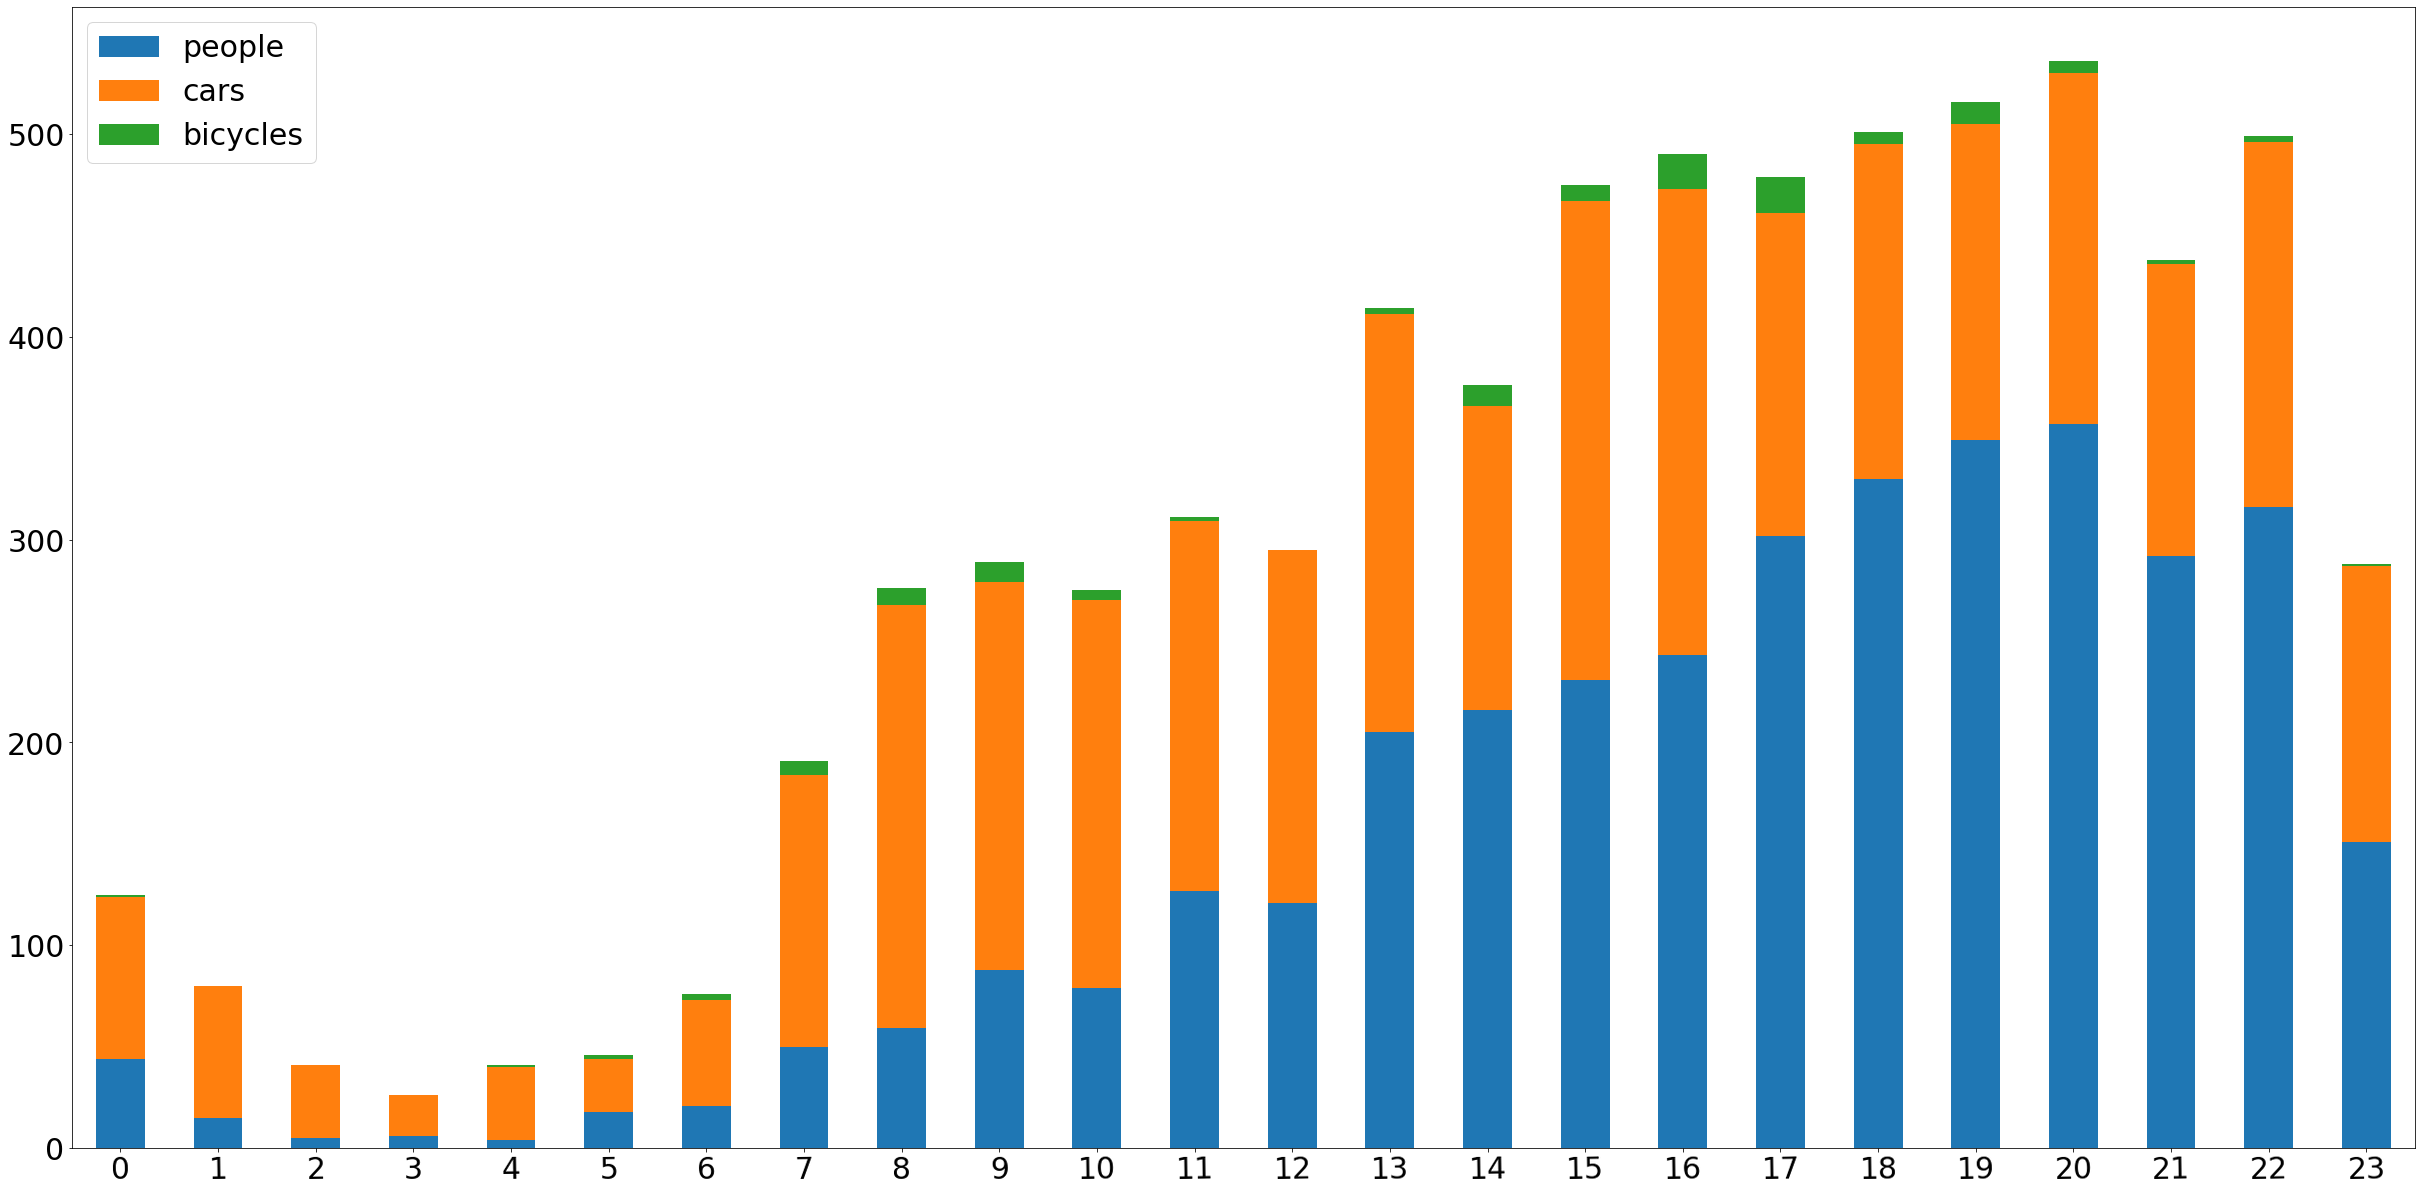

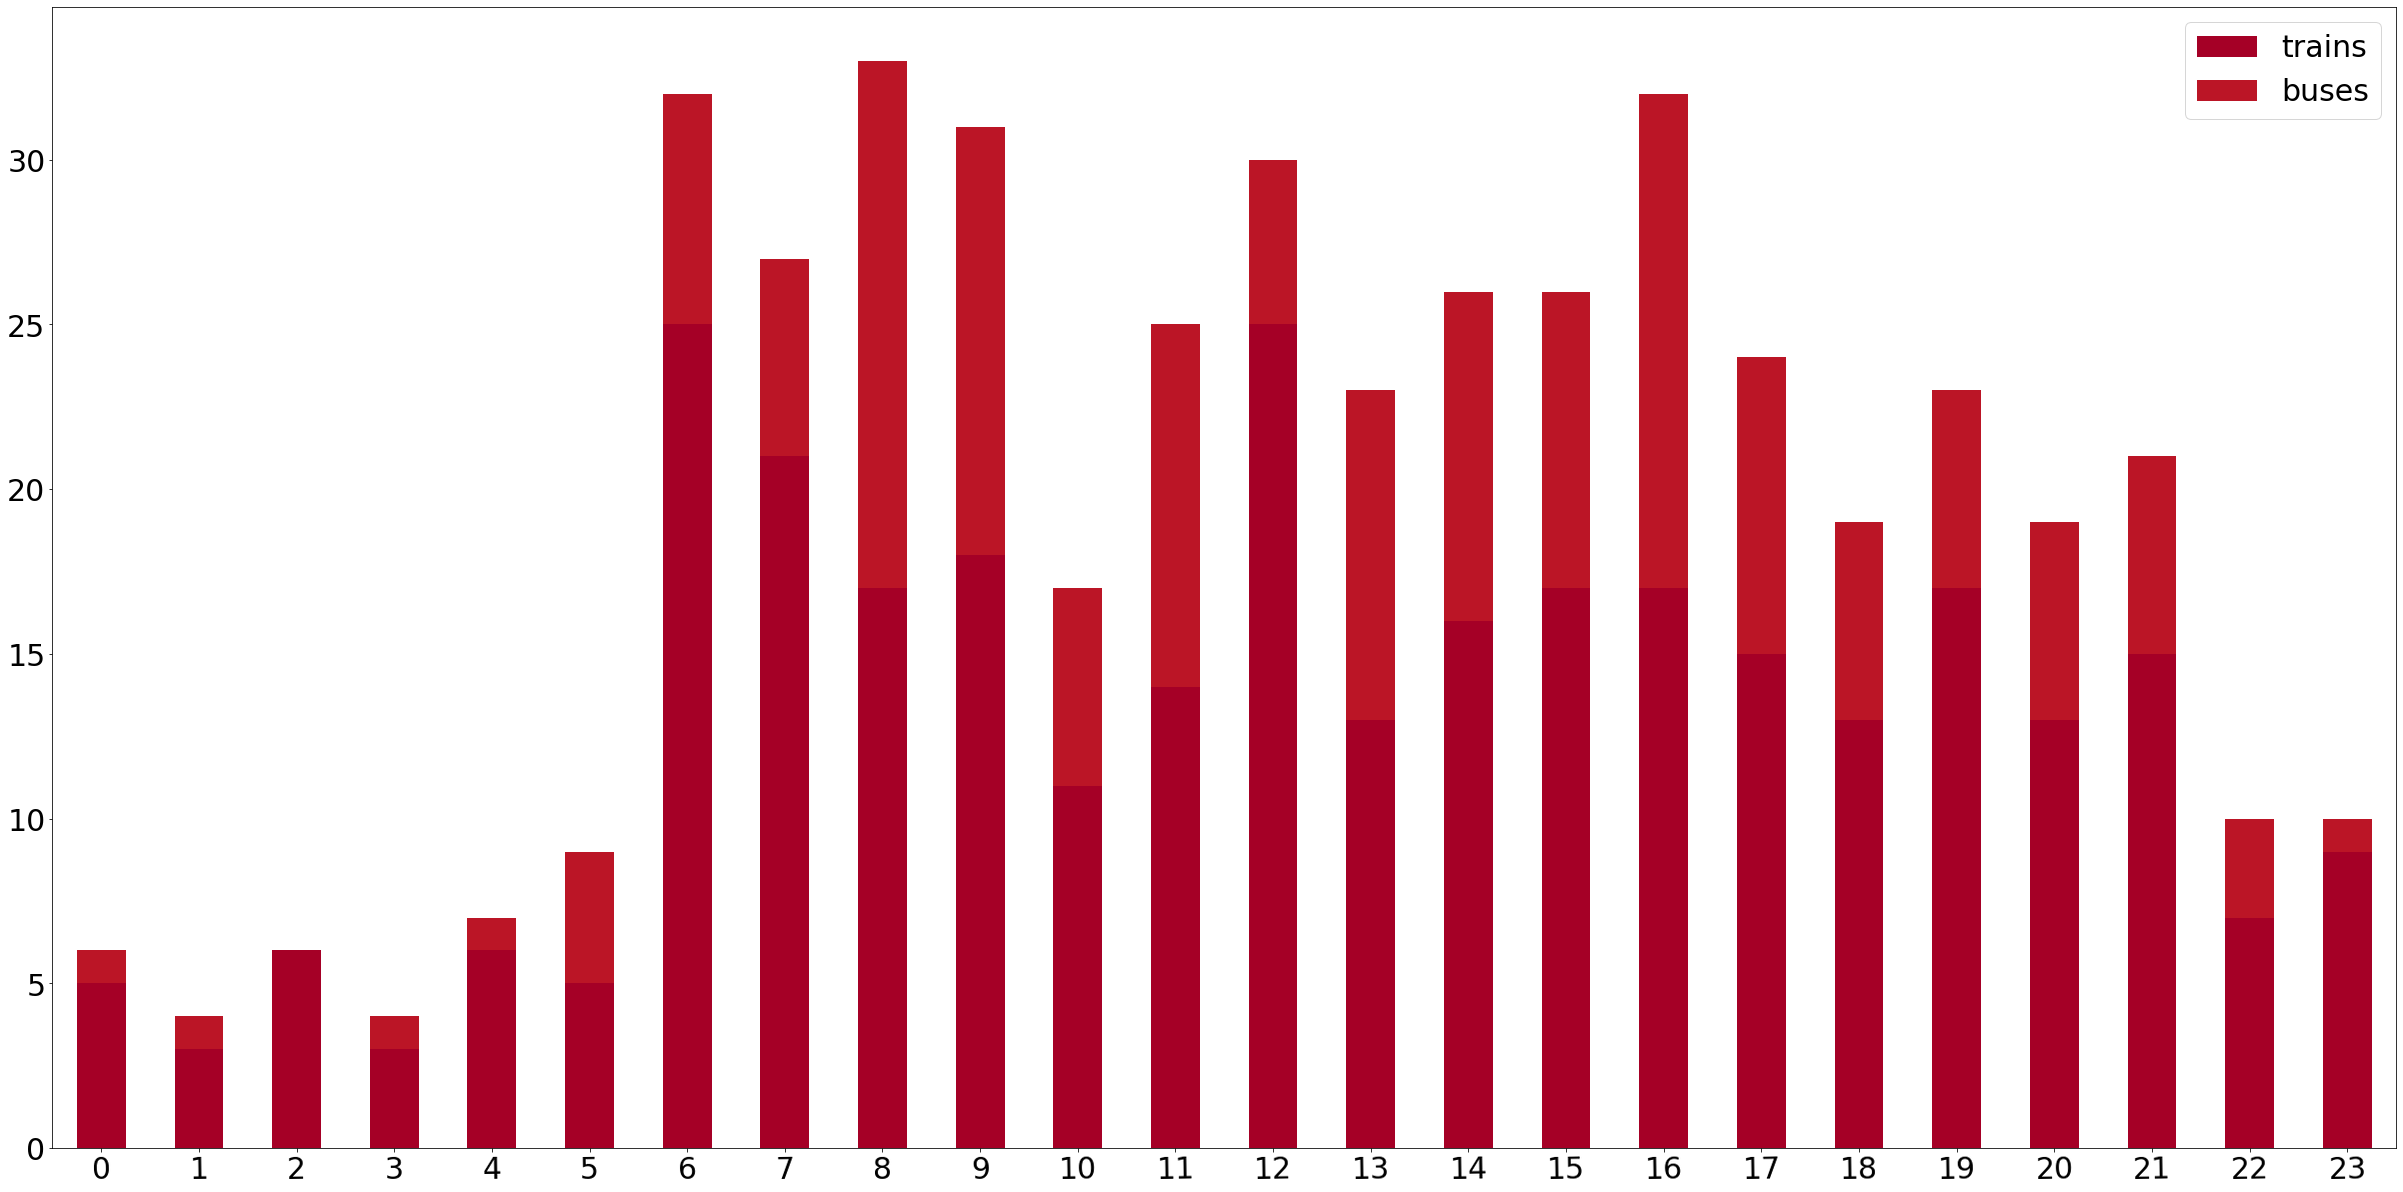

In [9]:
import pandas as pd
import matplotlib.cm as cm

# Create Pandas dataframe from dictionary and print its content.
df = pd.DataFrame.from_dict(hour_bins, orient='index')
print(df)

plt.rcParams['figure.figsize'] = [42, 21]

# Show plot with people, cars and bicycles.
df[["people","cars","bicycles"]].plot(kind="bar", stacked=True, fontsize=30, rot=1)
plt.legend(prop={'size': 30})
plt.show()

# Show plot with trains and buses.
colors = cm.RdYlGn(np.linspace(0,1,len(df)))
df[["trains","buses"]].plot(kind="bar", stacked=True, fontsize=30, rot=1, color=colors)
plt.legend(prop={'size': 30})
plt.show()